# Plant Disease Classification with ResNet
In this notebook, we'll train a ResNet model for classifying plant diseases using the PlantVillage dataset. We'll cover data loading, training, validation, and evaluation of the model, as well as visualize the results and test the model on a single image.

In [1]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image

## Setup
We'll start by setting up the device for training and defining the data transformations.

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Load and Split Dataset
We load the dataset, split it into training, validation, and test sets, and create data loaders.

In [3]:
# Load the dataset
data_dir = r"C:\Users\Walker\Research Seminar\PlantVillage"
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=data_transforms)

# Split the dataset
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class_names = dataset.classes
print('num_classes :', len(class_names))
print('class_names :', class_names)

num_classes : 16
class_names : ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'PlantVillage', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


## Model Setup
We load a pre-trained ResNet model, modify the final fully connected layer for our specific number of classes, and set up the loss function and optimizer.

In [4]:
# Load pre-trained ResNet model
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Modify the final fully connected layer
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training and Validation Functions
We define functions for training and validating the model.

In [5]:
# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

## Training Loop
We train the model for a specified number of epochs and keep track of the best validation accuracy.

In [6]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []

# Training loop
num_epochs = 2
best_val_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

100%|████████████████████████████████████████████████████████████████████████████████| 194/194 [00:45<00:00,  4.26it/s]


Epoch 1/2
Train Loss: 1.0035, Train Acc: 0.4867
Val Loss: 0.9190, Val Acc: 0.4914


100%|████████████████████████████████████████████████████████████████████████████████| 194/194 [00:45<00:00,  4.31it/s]

Epoch 2/2
Train Loss: 0.8379, Train Acc: 0.4872
Val Loss: 0.8186, Val Acc: 0.4880


## Visualize Training and Validation Metrics
We plot the training and validation losses and accuracies to visualize the model's performance over epochs.

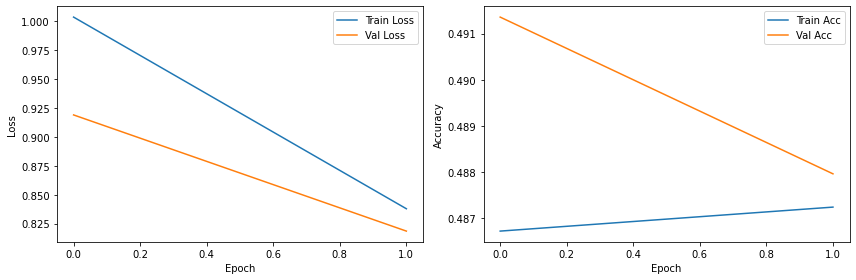

In [7]:
# Visualize training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate on Test Set
After training, we load the best model and evaluate its performance on the test set.

In [8]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████| 194/194 [00:47<00:00,  4.12it/s]

Test Loss: 0.9315, Test Acc: 0.4824


## Confusion Matrix
We compute and visualize the confusion matrix to understand the model's performance across different classes.

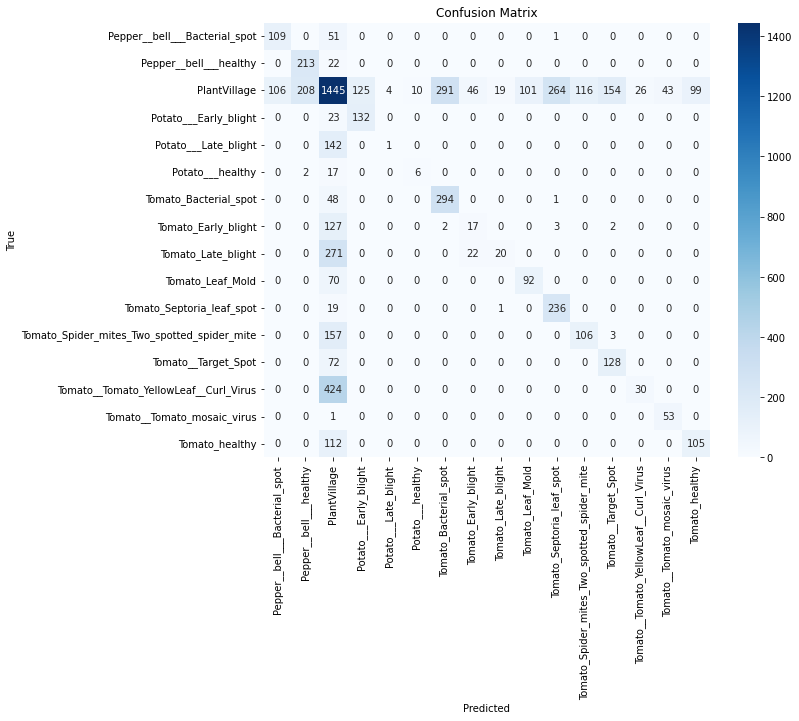

In [9]:
# Confusion Matrix
def get_all_preds(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

y_pred, y_true = get_all_preds(model, test_loader)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Single Image Prediction
We test the model on a single image and visualize the prediction along with the confidence score.

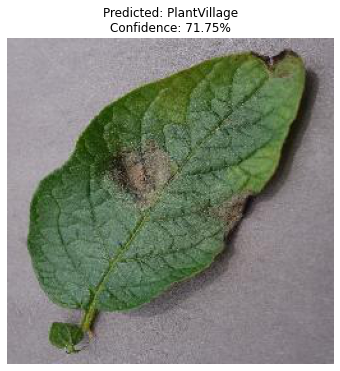

In [11]:
# Single image test
def predict_image(model, image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = data_transforms(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        probability = torch.nn.functional.softmax(output, dim=1)[0] * 100
    
    return class_names[predicted.item()], probability[predicted.item()].item()

# Test on a single image
test_image_path = r"C:\Users\Walker\Research Seminar\PlantVillage\Potato___Late_blight\006cc01a-1888-4326-9b62-a65cb55a6377___RS_LB 5207.JPG"  # Replace with an actual image path
predicted_class, confidence = predict_image(model, test_image_path)

plt.figure(figsize=(8, 6))
img = Image.open(test_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2f}%')
plt.show()